# Apply CNN Classifier to DESI Spectra

## SV0 and mini-SV2

Mini-SV2 tiles from February-March 2020:
- https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

See also the DESI tile picker with (limited) SV0 tiles from March 2020:
- https://desi.lbl.gov/svn/data/tiles/trunk/
- https://desi.lbl.gov/svn/data/tiles/trunk/SV0.html

## SV1

SV1 tiles from December-January 2020 are being updated daily on the wiki:
https://desi.lbl.gov/trac/wiki/SurveyValidation/SV1

See also the DESI e-log for a less curated list:
http://desi-www.kpno.noao.edu:8090/ECL/desi/E/search?text=sv1&search=Search

In [1]:
from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra
from desispec.coaddition import coadd_cameras
from desitarget.sv1.sv1_targetmask import bgs_mask

from desitrip.preproc import rebin_flux, rescale_flux

from astropy.io import fits
from astropy.table import Table, vstack, hstack, join

from glob import glob
from datetime import date

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras

In [2]:
mpl.rc('font', size=14)

In [3]:
# Set up BGS target bit selection.
sv1_bgs_bits = '|'.join([_ for _ in bgs_mask.names() if 'BGS' in _])

## Load the Keras Model

Load a model trained on real or simulated data using the native Keras output format. In the future this could be updated to just load the Keras weights.

In [4]:
tfmodel = '/global/homes/l/lehsani/timedomain/desitrip/docs/nb/models_9label_first/6_b65_e200_9label/b65_e200_9label_model'
# tfmodel = '/'.join([os.environ['HOME'], 'desi/timedomain/desitrip/docs/nb', '6label_cnn_restframe'])
if os.path.exists(tfmodel):
    classifier = keras.models.load_model(tfmodel)
else:
    classifier = None
    print('Sorry, could not find {}'.format(tfmodel))

In [5]:
if classifier is not None:
    classifier.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 150, 8)            48        
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 8)            32        
_________________________________________________________________
activation_20 (Activation)   (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 75, 8)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 16)            64    

## Loop Through Spectra and Classify

In [40]:
# Choose tiles from Dec/Jan 2020

bgs_tiles = 80611, 80612, 80613, 80614, 80616, 80617, 80618, 80619

# tile_id = 66000
# obsdate = 20200314

def get_petal_id(filename):
    return int(filename.split('-')[1])

def match_files(cafiles, zbfiles):  
    matched = [] 
    for _l1 in cafiles: 
        p1 = get_petal_id(_l1)  
        for _l2 in zbfiles: 
            p2 = get_petal_id(_l2) 
            if p1 == p2: 
                matched.append([_l1, _l2]) 
                break
    return matched 

# Access redux folder.
for bgs_tile in bgs_tiles:
    redux='/global/project/projectdirs/desi/spectro/redux/daily/tiles'
    prefix_in='/'.join([redux, '{:05d}'.format(bgs_tile)])
    if not os.path.isdir(prefix_in):
#         print('{} does not exist.'.format(prefix_in))
        continue
    else:
        subfolders = sorted(glob('{}/*'.format(prefix_in)))
        for sf in subfolders:
            obsdate = os.path.basename(sf)
            
            # Access the zbest and coadd files.
            # Files are organized by petal number.
            zbfiles = sorted(glob('{}/zbest*.fits'.format(sf)))
            cafiles = sorted(glob('{}/coadd*.fits'.format(sf)))
            
            # Loop through zbest and coadd files for each petal.
            # Extract the fibermaps, ZBEST tables, and spectra.
            # Keep only BGS targets passing basic event selection.
            allzbest = None
            allfmap = None
            allwave = None
            allflux = None
            allivar = None
            allmask = None
            allres  = None
            
            print('Tile: {} - {}'.format(bgs_tile, obsdate))
                
            for cafile, zbfile in match_files(cafiles, zbfiles):
                print('  - Petal {}'.format(get_petal_id(cafile)))

                # Access data per petal.
                zbest = Table.read(zbfile, 'ZBEST')
                pspectra = read_spectra(cafile)
                cspectra = coadd_cameras(pspectra)
                fibermap = cspectra.fibermap

                # Apply standard event selection.
                isTGT = fibermap['OBJTYPE'] == 'TGT'
                isGAL = zbest['SPECTYPE'] == 'GALAXY'
                isBGS = fibermap['SV1_BGS_TARGET'] & bgs_mask.mask(sv1_bgs_bits) != 0
                select = isTGT & isGAL & isBGS

                print('     + selected: {}'.format(np.sum(select)))

                # Accumulate spectrum data.
                if allzbest is None:
                    allzbest = zbest[select]
                    allfmap = fibermap[select]
                    allwave = cspectra.wave['brz']
                    allflux = cspectra.flux['brz'][select]
                    allivar = cspectra.ivar['brz'][select]
                    allmask = cspectra.mask['brz'][select]
                    allres  = cspectra.resolution_data['brz'][select]
                else:
                    allzbest = vstack([allzbest, zbest[select]])
                    allfmap = vstack([allfmap, fibermap[select]])
                    allflux = np.vstack([allflux, cspectra.flux['brz'][select]])
                    allivar = np.vstack([allivar, cspectra.ivar['brz'][select]])
                    allmask = np.vstack([allmask, cspectra.mask['brz'][select]])
                    allres  = np.vstack([allres, cspectra.resolution_data['brz'][select]])

#                 # Break loop over petals.
#                 break

    # Break loop over tiles.
    break

Tile: 80611 - 20201220
Tile: 80611 - 20201221
  - Petal 0
     + selected: 297
  - Petal 1
     + selected: 242
  - Petal 2
     + selected: 284
  - Petal 3
     + selected: 151
  - Petal 4
     + selected: 241
  - Petal 5
     + selected: 228
  - Petal 6
     + selected: 261
  - Petal 8
     + selected: 266


In [41]:
# Apply the DESITRIP preprocessing to selected spectra.
rewave, reflux, reivar = rebin_flux(allwave, allflux, allivar, allzbest['Z'],
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)
rsflux = rescale_flux(reflux)

In [42]:
# Run the classifier on the spectra.
# The output layer uses softmax activation to produce an array of label probabilities.
# The classification is based on argmax(pred).
pred = classifier.predict(rsflux)

In [43]:
pred.shape

(1967, 9)

In [44]:
ymax = np.max(pred, axis=1)

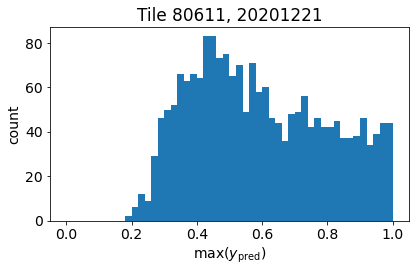

In [46]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)
ax.hist(ymax, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count',
       title='Tile {}, {}'.format(bgs_tile, obsdate));

### Selection on Classifier Output

To be conservative we can select only spectra where the classifier is very confident in its output, e.g., ymax > 0.99. See the [CNN training notebook](https://github.com/desihub/timedomain/blob/master/desitrip/docs/nb/cnn_multilabel-restframe.ipynb) for the motivation behind this cut.

In [47]:
idx = np.argwhere(ymax > 0.99)
labels = np.argmax(pred, axis=1)

In [48]:
idx.shape

(19, 1)

In [49]:
# Randomly select 16 of the spectra and plot them.
selection = sorted(np.random.choice(idx.flatten(), size=np.minimum(len(idx), 16), replace=False))

0.24399553834656054
0.25757904837871237
0.15969294678388452
0.2631770028677851
0.400157471674798
0.36565848977105464
0.2060662422273804
0.1319926474796959
0.15577413195927847
0.2508745974170734
0.2782008614965993
0.27656139446682043
0.32228034732138555
0.4760908021676684
0.3096804814374376
0.31128909980374786


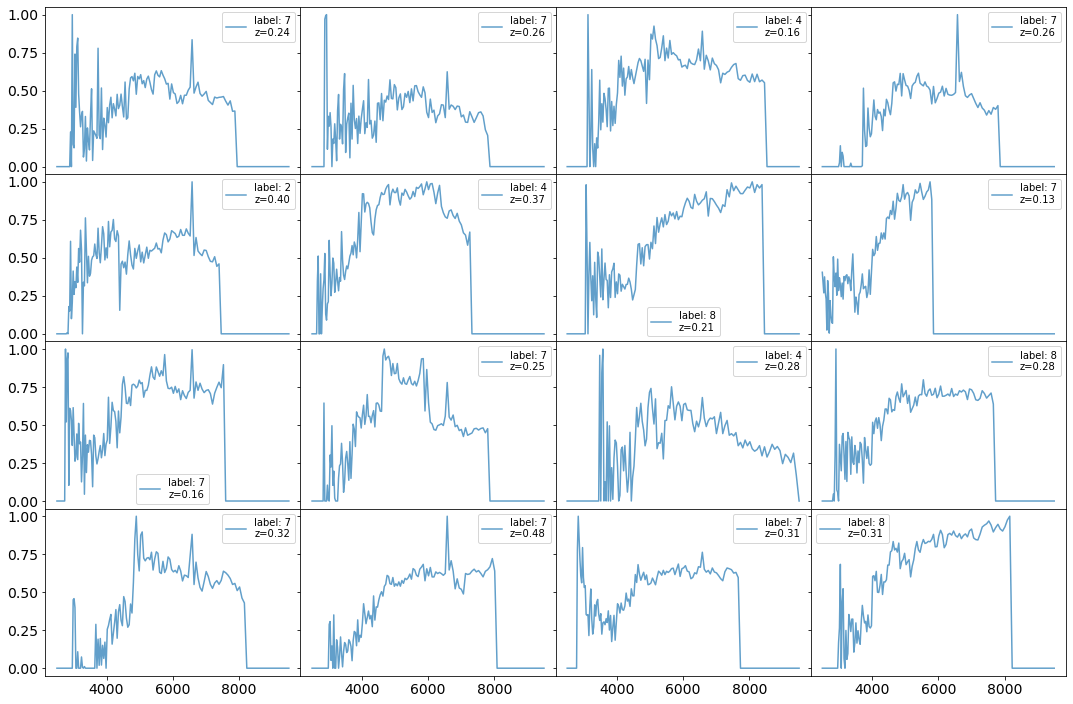

In [50]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(rewave, rsflux[j], alpha=0.7, label='label: {}\nz={:.2f}'.format(labels[j], allzbest[j]['Z']))
    print(allzbest[j]['Z'])
    ax.legend(fontsize=10)

# for k in [0,1,2]:
#     axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#     axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
#                   xlim=(3500,9900))
fig.tight_layout();

In [51]:
testwave, testflux, testivar = rebin_flux(allwave, allflux, allivar,
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)

0.24399553834656054
0.25757904837871237
0.15969294678388452
0.2631770028677851
0.400157471674798
0.36565848977105464
0.2060662422273804
0.1319926474796959
0.15577413195927847
0.2508745974170734
0.2782008614965993
0.27656139446682043
0.32228034732138555
0.4760908021676684
0.3096804814374376
0.31128909980374786


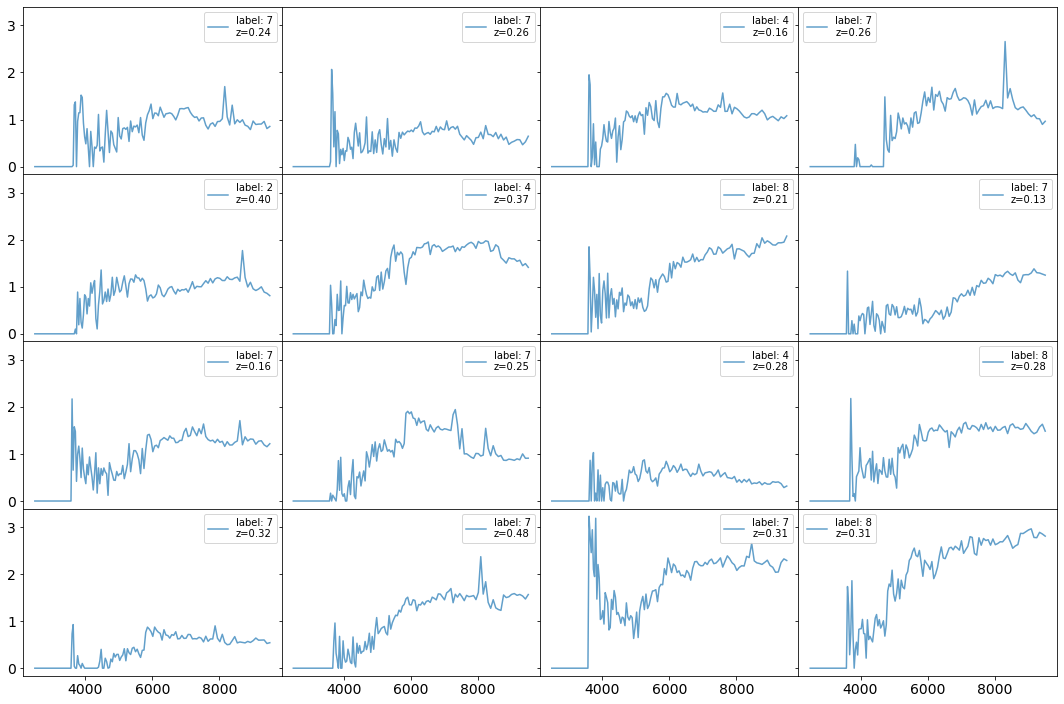

In [52]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(testwave, testflux[j], alpha=0.7, label='label: {}\nz={:.2f}'.format(labels[j], allzbest[j]['Z']))
    print(allzbest[j]['Z'])
    ax.legend(fontsize=10)

# for k in [0,1,2]:
#     axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#     axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
#                   xlim=(3500,9900))
fig.tight_layout();